## A Detailed Decomposition of the Market Composition

In [158]:
import os
os.environ['TIINGO_API_KEY'] = "put your own key here"
finnhub_token = 'put your own key here'

In [159]:
import pandas as pd
import requests
from pandas_datareader import data as web
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
%matplotlib inline

**First we are going to gather the necessary data to perform our analysis.**

**We need to get a list of all of the companies in the S&P 500, along with their size. I am going to use a dataset based on the holdings of the popular ETF, SPY, and use the weights as a proxy for their size. The ETF weights companies based on their market capitalization, so it should serve its purpose**

In [160]:
constituents = requests.get('https://finnhub.io/api/v1/etf/holdings?symbol=SPY&token={}'.format(finnhub_token))

In [161]:
constituents_df = pd.DataFrame.from_records(constituents.json()['holdings'])

In [162]:
constituents_df.head(10)

,percent,share,symbol
0,5.918711,43766308,AAPL
1,5.815551,81420240,MSFT
2,4.730508,4501968,AMZN
3,2.180427,25837586,FB
4,1.710792,3224102,GOOGL
5,1.670869,3142476,GOOG
6,1.479941,28309444,JNJ
7,1.397719,20891280,BRK.B
8,1.228678,18128360,V
9,1.162121,26593612,PG


**Now that we have a nice list of the companies along with weights, we need to get price data so we can calculate trailing returns for each company, before we move to the next step.**
1. First we are going to drop the last row, which has None as the ticker, which means it is probably cash in the ETF
2. We are going to use adjusted close prices instead of unadjusted, to account for any dividends or splits in the companies, to put every company on the same page.

In [163]:
constituents_df = constituents_df.iloc[:505]
constituents_df.loc[:, 'symbol'] = constituents_df['symbol'].apply(lambda x: x.replace(".", "-"))

In [164]:
tickers = list(set(constituents_df['symbol'].to_list()))

In [165]:
adjusted_close = pd.DataFrame(columns=tickers)
null_tickers = []

for ticker in tickers:
  try:
    data_panel = web.DataReader([ticker], "tiingo").loc[ticker]['adjClose'].to_frame()
    data_panel.columns = [ticker]
    data_panel.index = pd.to_datetime(data_panel.index)
    if data_panel.index.max().tz_localize(None) < datetime.today() - relativedelta(days=5):
        print("{} most recent date is {}".format(ticker, str(data_panel.index.max())))
    else:
        adjusted_close[ticker] = data_panel[ticker]
  except:
    null_tickers.append(ticker)
    print("{} not found".format(ticker))

In [166]:
filtered_adjusted_close = adjusted_close.loc['2019-12-31':]

In [167]:
constituents_df.set_index('symbol', inplace=True)

**I am interested in breaking up the returns this year into 4 groups or intervals.**
1. The return year-to-date (from the start of the year to today)
2. The return peak-to-trough (from the peak of the market to the trough of the market this year)
3. The return trough-to-date (from the market bottom to today)
4. The return start-to-peak (from the start of the year to the peak, right before the crash)

In [168]:
peak = '2020-02-19'
trough = '2020-03-23'

In [169]:
for ticker in filtered_adjusted_close.columns:
    constituents_df.loc[ticker, 'ytd_return'] = (filtered_adjusted_close[ticker].iloc[-1] - filtered_adjusted_close[ticker].iloc[0])/filtered_adjusted_close[ticker].iloc[0]
    constituents_df.loc[ticker, 'peak_to_trough'] = (filtered_adjusted_close[ticker].loc[trough] - filtered_adjusted_close[ticker].loc[peak])/filtered_adjusted_close[ticker].loc[peak]
    constituents_df.loc[ticker, 'trough_to_date'] = (filtered_adjusted_close[ticker].iloc[-1] - filtered_adjusted_close[ticker].loc[trough])/filtered_adjusted_close[ticker].loc[trough]
    constituents_df.loc[ticker, 'start_to_peak'] = (filtered_adjusted_close[ticker].loc[peak] - filtered_adjusted_close[ticker].iloc[0])/filtered_adjusted_close[ticker].iloc[0]

In [170]:
constituents_df.head(10)

,percent,share,ytd_return,peak_to_trough,trough_to_date,start_to_peak
symbol,,,,,,
AAPL,5.918711,43766308,0.469236,-0.306687,0.918285,0.104712
MSFT,5.815551,81420240,0.282050,-0.273921,0.482793,0.190805
AMZN,4.730508,4501968,0.623441,-0.123209,0.576525,0.174463
FB,2.180427,25837586,0.213252,-0.319049,0.681431,0.059635
GOOGL,1.710792,3224102,0.052263,-0.308708,0.337017,0.138481
GOOG,1.670869,3142476,0.058481,-0.307901,0.339375,0.141860
JNJ,1.479941,28309444,0.010278,-0.248935,0.317402,0.021046
BRK-B,1.397719,20891280,-0.074570,-0.292750,0.292851,0.012097
V,1.228678,18128360,0.044607,-0.363649,0.443923,0.136874


**Next, we are going to split up the S&P 500 by market cap into deciles, which should give us around 50 companies per decile. We will be using these deciles to group the returns of the companies, to see if there is any pattern or information that may be interesting.**

In [171]:
constituents_df.loc[:, 'decile'] = pd.qcut(constituents_df['percent'].to_list(), 10, labels=False)

**Decile 9 is the 50 largest companies, while decile 0 represents the 50 smallest companies in the index**

In [172]:
constituents_df

,percent,share,ytd_return,peak_to_trough,trough_to_date,start_to_peak,decile
symbol,,,,,,,
AAPL,5.918711,43766308,0.469236,-0.306687,0.918285,0.104712,9
MSFT,5.815551,81420240,0.282050,-0.273921,0.482793,0.190805,9
AMZN,4.730508,4501968,0.623441,-0.123209,0.576525,0.174463,9
FB,2.180427,25837586,0.213252,-0.319049,0.681431,0.059635,9
GOOGL,1.710792,3224102,0.052263,-0.308708,0.337017,0.138481,9
...,...,...,...,...,...,...,...
GPS,0.010548,2304094,-0.051324,-0.634459,1.635350,-0.015211,0
UAA,0.007050,1942878,-0.470833,-0.513579,0.418114,-0.232870,0
UA,0.006668,2071528,-0.478624,-0.522727,0.400560,-0.220021,0


**Now that we have all of the data we need to start digging in, we are going to group the data by decile, and look at some descriptive statistics for each return interval. This will give us the average, min, max, standard deviation, etc. so it will be helpful to get a peak into the variation within each group.**

In [173]:
constituents_df.groupby('decile')['ytd_return'].describe()

,count,mean,std,min,25%,50%,75%,max
decile,,,,,,,,
0,51.0,-0.361757,0.275103,-0.740284,-0.533002,-0.415173,-0.290259,0.682426
1,50.0,-0.193704,0.233456,-0.718744,-0.323039,-0.210089,-0.114146,0.587410
2,51.0,-0.115670,0.236562,-0.649174,-0.261785,-0.121119,0.001729,0.524767
3,50.0,-0.102911,0.232186,-0.731030,-0.284916,-0.083619,0.068838,0.416864
4,51.0,-0.012489,0.256862,-0.562281,-0.178875,-0.017957,0.109715,0.789365
5,48.0,-0.086948,0.202346,-0.575181,-0.200709,-0.068079,0.046012,0.361301
6,50.0,-0.023803,0.260095,-0.556683,-0.210106,-0.003814,0.129845,0.491309
7,51.0,0.030680,0.238403,-0.479776,-0.131881,0.010095,0.137846,0.764972
8,50.0,0.018359,0.269111,-0.560666,-0.177307,0.001764,0.202872,0.631022


Interesting, so far this year there has been an almost linear relationship between size and the magnitude of return for each batch of companies. The 51 largest companies (decile 9) have return roughly 8.25% on average, while the bottom 51 (decile 0) have returned -37.2% roughly. The second largest group, for comparison, return 3.24% on average and the second smallest group returned -16.73% on average.

One thing to note, is that the standard deviation was actually higher for the 51 largest companies, relative to the 51 smallest, which means not every company in the top 51 benefited as much as the average implies. The worst of the top 51 is down 37.6% YTD, while the best is up 81.26%!

In [174]:
constituents_df.groupby('decile')['peak_to_trough'].describe()

,count,mean,std,min,25%,50%,75%,max
decile,,,,,,,,
0,51.0,-0.544885,0.124625,-0.848613,-0.632865,-0.533997,-0.458527,-0.235627
1,50.0,-0.426122,0.152007,-0.743048,-0.505031,-0.432222,-0.334520,-0.093590
2,51.0,-0.418262,0.138979,-0.762157,-0.505906,-0.421385,-0.331606,-0.132745
3,50.0,-0.400695,0.154246,-0.757659,-0.471202,-0.400703,-0.316084,0.092786
4,51.0,-0.346275,0.138485,-0.633895,-0.440915,-0.352053,-0.258753,-0.002328
5,48.0,-0.411574,0.118316,-0.711908,-0.499475,-0.418547,-0.318803,-0.169801
6,50.0,-0.374610,0.127997,-0.605005,-0.457082,-0.381765,-0.315632,0.052133
7,51.0,-0.335487,0.107150,-0.585724,-0.403734,-0.331818,-0.286962,-0.095206
8,50.0,-0.334608,0.144594,-0.687792,-0.423223,-0.351906,-0.280180,0.136773


Now, from the peak on 2-19-2020 to the trough on 3-23-2020, the hardest hit companies were definitely in the lower deciles, again, almost in perfect linear fashion. The 51 largest companies on average fell 29%, while the 51 smallest companies fell by 54% on average. This may explain the disconnect in performance YTD across the deciles, but lets keep going.

In [175]:
constituents_df.groupby('decile')['trough_to_date'].describe()

,count,mean,std,min,25%,50%,75%,max
decile,,,,,,,,
0,51.0,0.486848,0.467512,-0.433010,0.162753,0.416067,0.638598,2.282443
1,50.0,0.436507,0.418166,-0.087039,0.184367,0.302439,0.563996,1.785619
2,51.0,0.520162,0.313662,0.035517,0.272221,0.483365,0.688861,1.429400
3,50.0,0.494735,0.345187,-0.033762,0.241289,0.476579,0.649846,1.602583
4,51.0,0.489281,0.354146,0.004595,0.256936,0.431013,0.612724,1.740260
5,50.0,0.558957,0.328029,-0.149710,0.362342,0.511366,0.678417,1.531908
6,50.0,0.502220,0.268148,-0.177481,0.288539,0.501251,0.700160,1.120552
7,51.0,0.464633,0.249492,0.011182,0.293393,0.439894,0.627419,1.177345
8,50.0,0.450687,0.262648,-0.114010,0.295203,0.419168,0.607576,1.362199


Looking at the deciles from the market bottom on 3-23 to today, it is much more even. The standard deviation is about 50% lower for the largest companies relative to the smallest, which means there was a very wide dispersion amongst the smallest 51 companies. The best performer in the smallest companies returned 262%, while the worst fell another 22% from the bottom..

In [176]:
constituents_df.groupby('decile')['start_to_peak'].describe()

,count,mean,std,min,25%,50%,75%,max
decile,,,,,,,,
0,51.0,-0.045662,0.110187,-0.233767,-0.120562,-0.029722,0.025701,0.357616
1,50.0,0.014358,0.100328,-0.198018,-0.055254,0.006523,0.079673,0.223165
2,51.0,0.019718,0.100213,-0.181313,-0.050403,0.017610,0.073119,0.378682
3,50.0,0.025327,0.091033,-0.152274,-0.055989,0.020843,0.104207,0.225563
4,51.0,0.032224,0.096794,-0.163155,-0.043005,0.049676,0.099346,0.264938
5,48.0,0.023937,0.087010,-0.150016,-0.026984,0.011011,0.077885,0.214647
6,50.0,0.041920,0.100891,-0.198915,-0.035336,0.055233,0.114250,0.286351
7,51.0,0.062912,0.088798,-0.166667,0.015278,0.065670,0.107925,0.333455
8,50.0,0.059398,0.084855,-0.115417,0.022958,0.065255,0.107521,0.284344


Finally, looking at the deciles from the start of the year to the peak on 2-19, we can see that the largest companies were doing the best going into the market drop and the smaller companies were off to a fairly rocky 2020. 

To recap, the bigger companies:

1. Were off to the best start before the COVID market crash.
2. Declined the least, on average, compared to smaller companies.
3. Recovered around the same on average, from the trough of the market to today.
4. Have the best returns on average, from the start of the year to date.

Next, we are going to look at the actual return contribution of each company and decile. To calculate this, we are going to multiply each return series by the companies corresponding weight in the index (as approximated by the weight in the SPY ETF). We will then be able to see what the effect has been on the total index return in each time period.

In [177]:
constituents_df.loc[:, 'weight'] = constituents_df['percent'].apply(lambda x: x/constituents_df['percent'].sum())

In [178]:
constituents_df

,percent,share,ytd_return,peak_to_trough,trough_to_date,start_to_peak,decile,weight
symbol,,,,,,,,
AAPL,5.918711,43766308,0.469236,-0.306687,0.918285,0.104712,9,0.059189
MSFT,5.815551,81420240,0.282050,-0.273921,0.482793,0.190805,9,0.058157
AMZN,4.730508,4501968,0.623441,-0.123209,0.576525,0.174463,9,0.047307
FB,2.180427,25837586,0.213252,-0.319049,0.681431,0.059635,9,0.021805
GOOGL,1.710792,3224102,0.052263,-0.308708,0.337017,0.138481,9,0.017108
...,...,...,...,...,...,...,...,...
GPS,0.010548,2304094,-0.051324,-0.634459,1.635350,-0.015211,0,0.000105
UAA,0.007050,1942878,-0.470833,-0.513579,0.418114,-0.232870,0,0.000071
UA,0.006668,2071528,-0.478624,-0.522727,0.400560,-0.220021,0,0.000067


In [179]:
constituents_df.loc[:, 'return_contribution_ytd'] = constituents_df['weight'] * constituents_df['ytd_return']
constituents_df.loc[:, 'return_contribution_ptt'] = constituents_df['weight'] * constituents_df['peak_to_trough']
constituents_df.loc[:, 'return_contribution_ttd'] = constituents_df['weight'] * constituents_df['trough_to_date']
constituents_df.loc[:, 'return_contribution_stp'] = constituents_df['weight'] * constituents_df['start_to_peak']

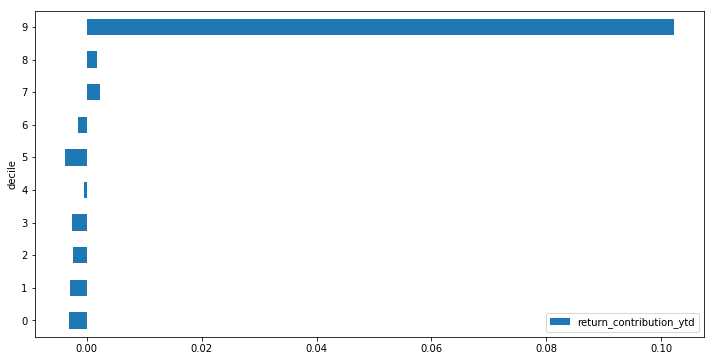

In [180]:
constituents_df.groupby('decile')['return_contribution_ytd'].sum().plot(kind='barh', figsize=[12,6], legend=True) # alpha for transparency

In [181]:
constituents_df['return_contribution_ytd'].sum()

0.08961325361431384

In [182]:
constituents_df.groupby('decile')['return_contribution_ytd'].sum() / constituents_df['return_contribution_ytd'].sum()

decile
0   -0.033660
1   -0.033130
2   -0.026311
3   -0.029485
4   -0.005181
5   -0.042286
6   -0.016872
7    0.026067
8    0.020668
9    1.140191
Name: return_contribution_ytd, dtype: float64

The results are very interesting, you can see in the chart that the only meaningful return when accounting for the weights has come from the top 51 companies. When you total the return for decile 9, and put it over the total of the return for the whole index, it accounts for 104.6% of the index return to-date! Meaning the top 51 companies are pulling up the index performance drastically..

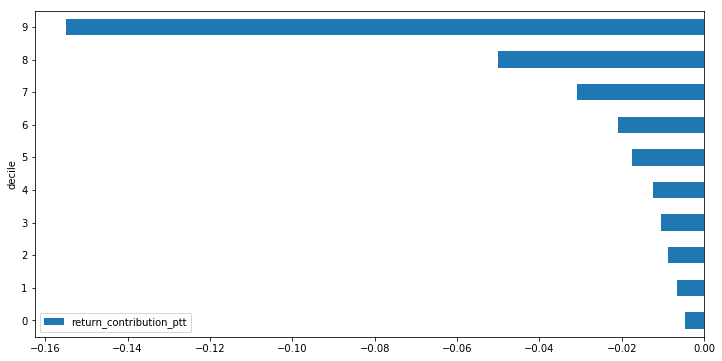

In [183]:
constituents_df.groupby('decile')['return_contribution_ptt'].sum().plot(kind='barh', figsize=[12,6], legend=True) # alpha for transparency

In [184]:
constituents_df.groupby('decile')['return_contribution_ptt'].sum() / constituents_df['return_contribution_ptt'].sum()

decile
0    0.014632
1    0.020735
2    0.027868
3    0.033228
4    0.038980
5    0.055400
6    0.066126
7    0.097248
8    0.157604
9    0.488179
Name: return_contribution_ptt, dtype: float64

On the flipside, while the top 51 companies declined the least during the market drop, their weights in the index had them contribute the most to the negative performance. This is purely a function of their weights in the index and not much else.

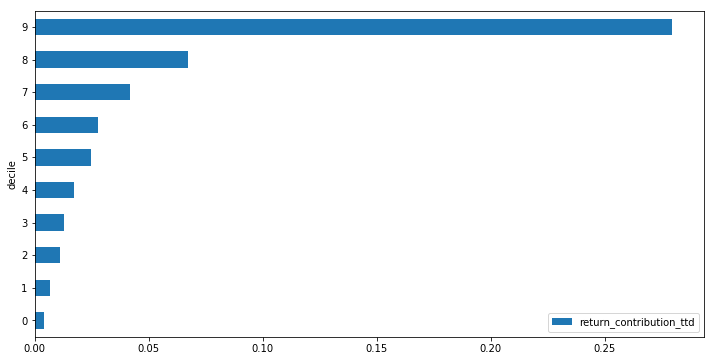

In [185]:
constituents_df.groupby('decile')['return_contribution_ttd'].sum().plot(kind='barh', figsize=[12,6], legend=True) # alpha for transparency

In [186]:
constituents_df.groupby('decile')['return_contribution_ttd'].sum() / constituents_df['return_contribution_ttd'].sum()

decile
0    0.008497
1    0.013830
2    0.022387
3    0.026453
4    0.035411
5    0.049885
6    0.056228
7    0.085021
8    0.136124
9    0.566164
Name: return_contribution_ttd, dtype: float64

From the bottom of the market in March, no surprises here, the top 51 companies contributed the most because of their weight and positive performance.

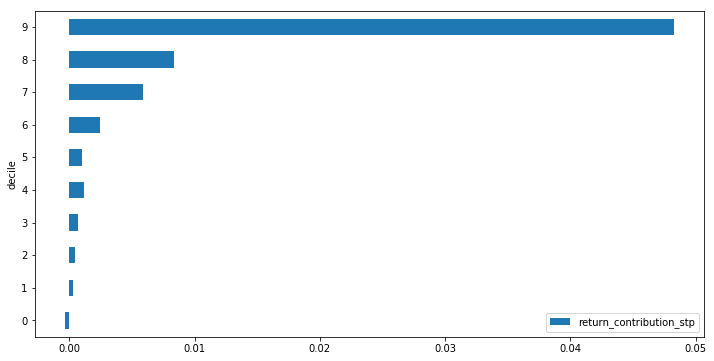

In [187]:
constituents_df.groupby('decile')['return_contribution_stp'].sum().plot(kind='barh', figsize=[12,6], legend=True) # alpha for transparency

In [188]:
constituents_df.groupby('decile')['return_contribution_stp'].sum() / constituents_df['return_contribution_stp'].sum()

decile
0   -0.005149
1    0.003750
2    0.006610
3    0.010232
4    0.017272
5    0.014333
6    0.035481
7    0.086102
8    0.122381
9    0.708988
Name: return_contribution_stp, dtype: float64

Finally, from the start of the year to the day before the market started on it's downward spiral, 70% of the market's positive performance came from the top 51 companies.

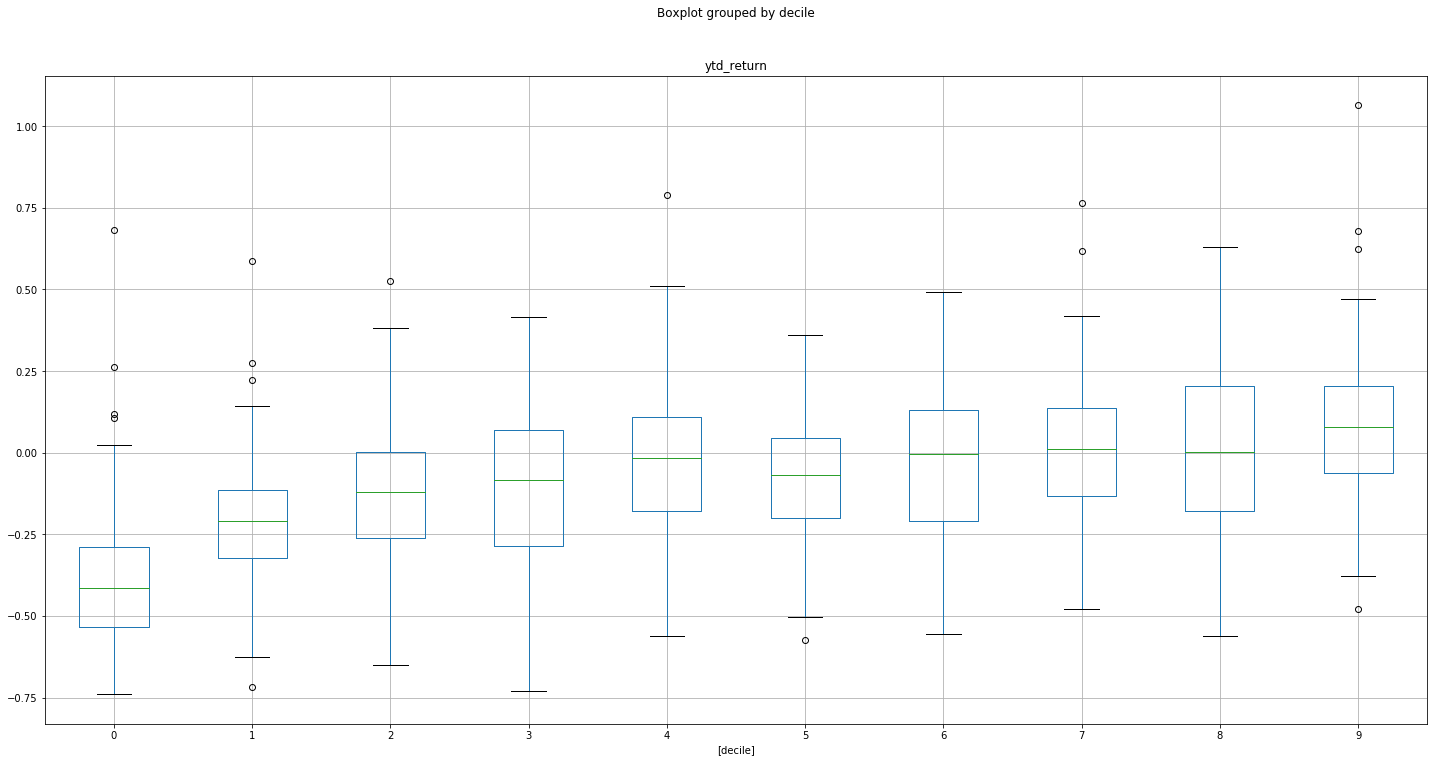

In [189]:
boxplot = constituents_df.boxplot(column=['ytd_return'], by=['decile'], figsize=[24,12])

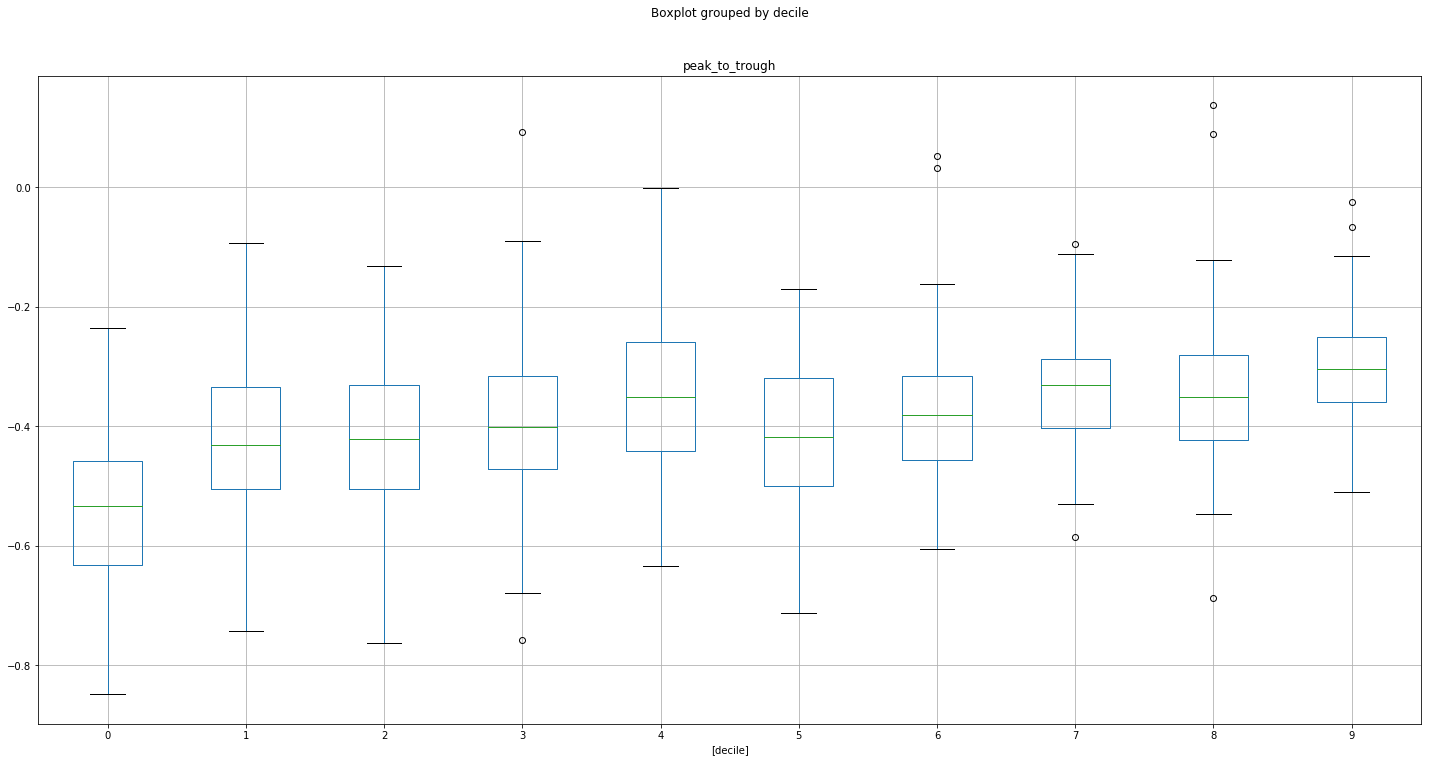

In [190]:
boxplot = constituents_df.boxplot(column=['peak_to_trough'], by=['decile'], figsize=[24,12])

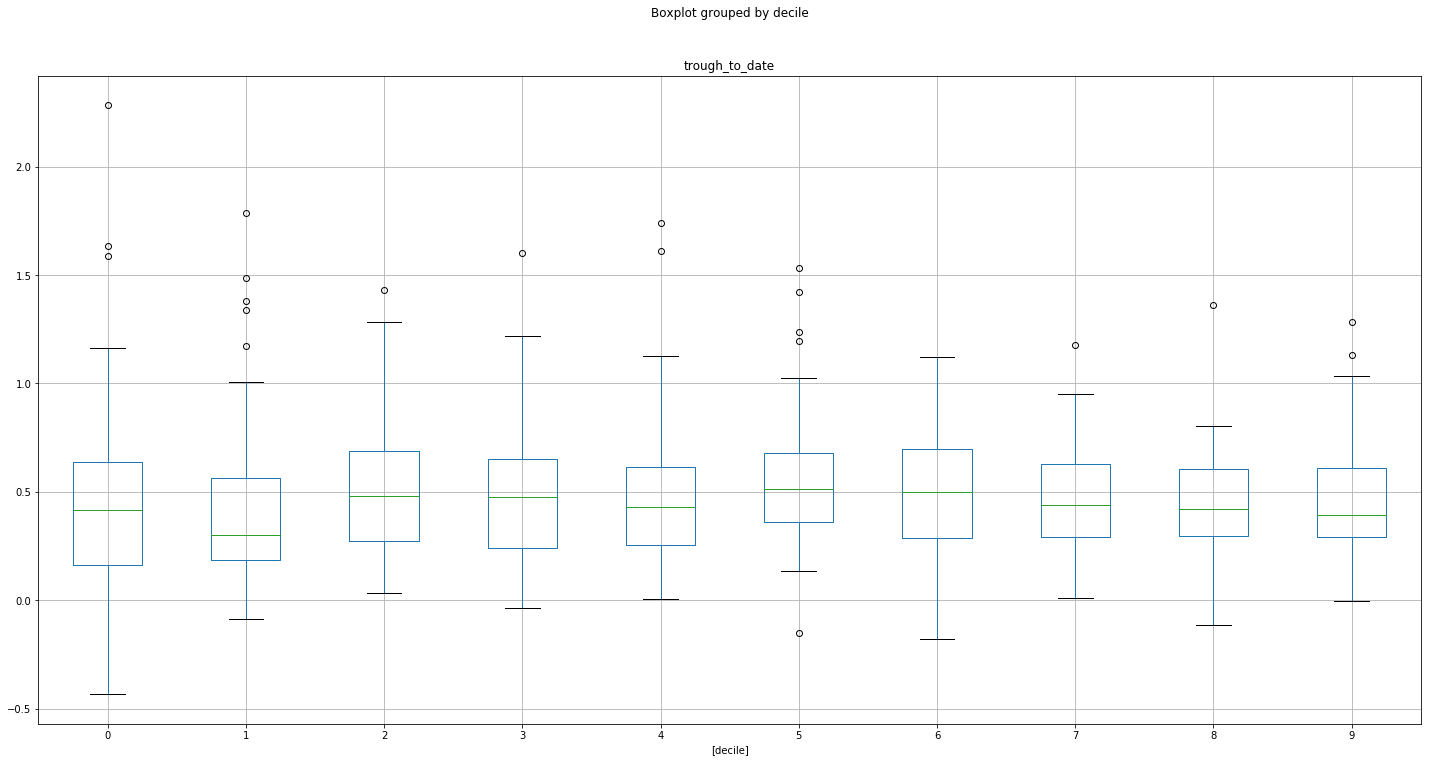

In [191]:
boxplot = constituents_df.boxplot(column=['trough_to_date'], by=['decile'], figsize=[24,12])

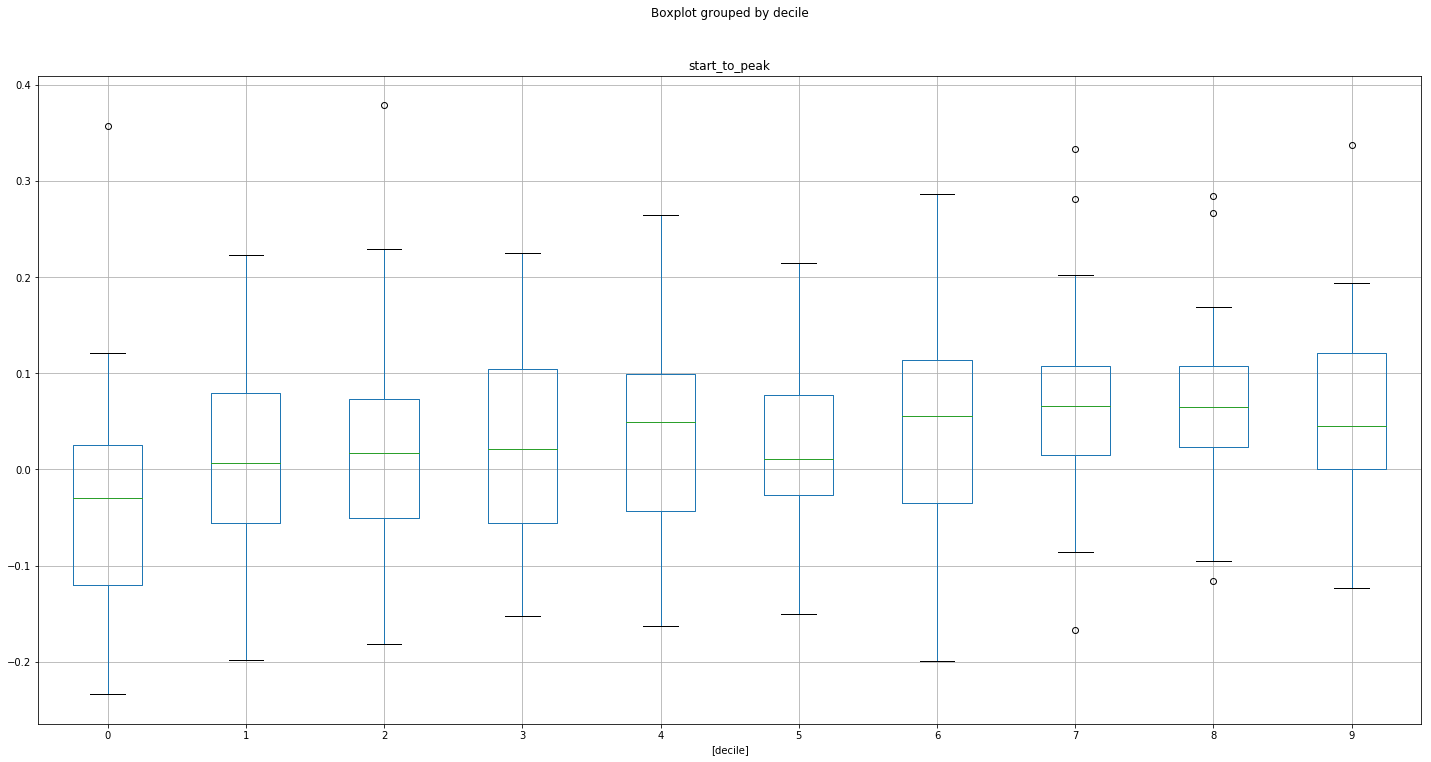

In [192]:
boxplot = constituents_df.boxplot(column=['start_to_peak'], by=['decile'], figsize=[24,12])

What about more broadly? Lets dive into the Russell 3000 constituents to see if we can find similar distributions of returns.

In [193]:
russell_3000 = pd.read_csv('russell_3000.csv')

In [194]:
russell_3000.loc[:, 'mcap_decile'] = pd.qcut(russell_3000['market_cap'].to_list(), 10, labels=False)

In [195]:
russell_3000.loc[:, 'pe_decile'] = pd.qcut(russell_3000['pe_ratio'].to_list(), 10, labels=False, duplicates='drop')

In [196]:
russell_3000.loc[russell_3000['pe_decile'] == 0, 'pe_decile'] = 'no_earnings'
russell_3000['pe_decile'] = russell_3000['pe_decile'].astype(str)

In [197]:
mcap_decile_stats = russell_3000.groupby('mcap_decile')['ytd_return'].describe()
mcap_decile_stats

,count,mean,std,min,25%,50%,75%,max
mcap_decile,,,,,,,,
0,270.0,-0.392259,0.281965,-0.92,-0.5375,-0.440,-0.3100,1.15
1,270.0,-0.228704,0.390330,-0.90,-0.5000,-0.285,-0.0925,2.43
2,270.0,-0.094370,1.240263,-0.87,-0.4675,-0.305,-0.0700,14.23
3,269.0,-0.030929,1.313641,-0.80,-0.4300,-0.210,0.0800,19.86
4,270.0,-0.098370,0.512600,-0.71,-0.4100,-0.220,0.0075,3.09
5,270.0,-0.077889,0.567776,-0.76,-0.3500,-0.180,0.0275,6.39
6,269.0,0.046506,0.883623,-0.74,-0.3100,-0.130,0.1400,9.13
7,270.0,0.096778,1.569675,-0.68,-0.2500,-0.100,0.1000,24.55
8,270.0,0.072000,0.569468,-0.75,-0.2300,-0.045,0.1700,4.38


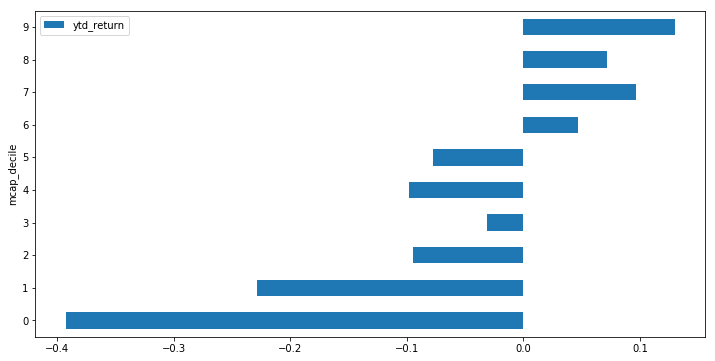

In [198]:
russell_3000.groupby('mcap_decile')['ytd_return'].mean().sort_index().plot(kind='barh', figsize=[12,6], legend=True)

Nothing too shocking here. Year-to-date, the largest 270 companies by market cap have outperformed the smallest 270 companies by over 50%. What is somewhat surprising to me is, if you look at the standard deviation for each decile, it is much lower (less than half) for the bottom decile than for the top decile. This means that in the bottom decile, the companies have all performed relatively poorly, and in the top decile, you have a much wider range of returns. That makes sense intuitively, since we uncovered a similar amount of dispersion between the deciles of the S&P 500 earlier in this notebook. In this example, the best performer year-to-date (the max column shows this) returned 636% while the worst performer returned -59% for the top decile. Conversely, the bottom decile's best performer returned 115%, while the worst was -92%. So it appears that the distribution may be skewed to the right for the megacap companies in the US while the smallest companies looks more evenly distributed around the mean, which makes sense given the data we have examined so far.

In [199]:
pe_decile_stats = russell_3000.groupby('pe_decile')['ytd_return'].describe()
pe_decile_stats

,count,mean,std,min,25%,50%,75%,max
pe_decile,,,,,,,,
1,269.0,-0.369591,0.221672,-0.78,-0.4900,-0.430,-0.3100,0.70
2,270.0,-0.250889,0.243552,-0.74,-0.4200,-0.280,-0.1600,0.73
3,270.0,-0.177444,0.270350,-0.76,-0.3300,-0.210,-0.0425,1.13
4,269.0,-0.111599,0.236732,-0.67,-0.2700,-0.110,0.0200,0.63
5,270.0,-0.051370,0.275376,-0.88,-0.2000,-0.060,0.0875,1.21
6,270.0,0.016852,0.389380,-0.67,-0.2175,-0.030,0.1875,1.75
7,270.0,0.170185,1.134109,-0.71,-0.2875,-0.050,0.2800,14.23
no_earnings,810.0,0.064827,1.439242,-0.92,-0.4700,-0.205,0.1700,24.55


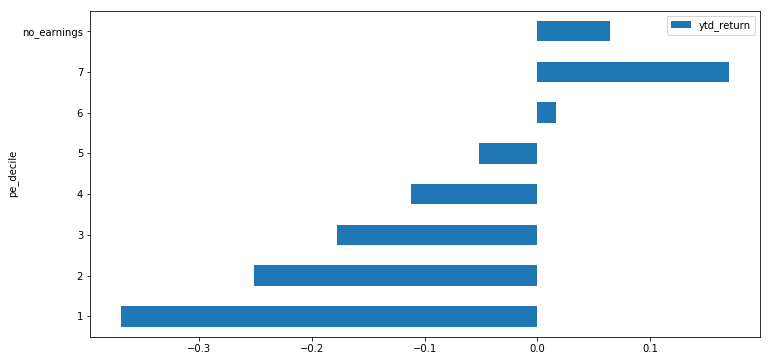

In [200]:
russell_3000.groupby('pe_decile')['ytd_return'].mean().sort_index().plot(kind='barh', figsize=[12,6], legend=True)

I decided to take this example one step further, by breaking down the same data into deciles by Price-to-earnings ratio to see if we find anything interesting. One thing to note - this was not as clean of an exercise as when we broke out deciles by market cap. Due to the fact that the P/E ratio can only be calculated if a company has earnings (shocker), it appears as though 810 companies for the 2700 or so examined do not have earnings. So, rather than exclude them altogether, I decided to put them into their own group for comparison purposes. The results are not surprising, given the fact that by now, most investors are aware of the chronic underperformance of value vs. growth stocks. The cheapest 269 companies underperformed the most expensive 270 companies year-to-date by almost 54%! Whats more, companies with negative or zero earnings have outperformed the cheapest stocks by over 42%. The distribution of returns for the expensive and no-earnings groups is much wider than that of the cheapest, with standard deviations of returns within the group roughly 5-6X greater than the low P/E companies.

In [201]:
sector_stats = russell_3000.groupby('sector')['ytd_return'].describe()
sector_stats

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
Communication Services,98.0,-0.081531,0.433112,-0.81,-0.3500,-0.180,0.1350,1.54
Consumer Discretionary,304.0,0.120592,1.101363,-0.86,-0.3100,-0.090,0.2100,9.19
Consumer Staples,100.0,-0.011800,0.467783,-0.74,-0.2425,-0.075,0.0925,3.09
Energy,104.0,-0.485962,0.288365,-0.90,-0.6725,-0.555,-0.3975,0.70
Financials,478.0,-0.314163,0.253560,-0.74,-0.4600,-0.390,-0.2400,1.15
Health Care,491.0,0.234481,1.695760,-0.88,-0.2700,-0.060,0.3200,24.55
Industrials,365.0,-0.104356,0.441116,-0.92,-0.3400,-0.150,0.0300,3.66
Information Technology,354.0,0.101610,0.608896,-0.78,-0.1900,-0.015,0.2375,6.36
Materials,119.0,-0.162437,0.219772,-0.63,-0.3100,-0.150,-0.0600,0.63


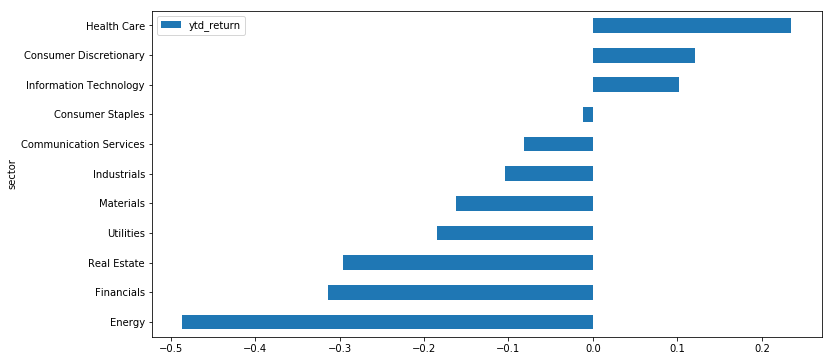

In [202]:
russell_3000.groupby('sector')['ytd_return'].mean().sort_values().plot(kind='barh', figsize=[12,6], legend=True)

What about sectors? Nothing shocking here, but wanted to show it anyway. Health care has been the best performer while Energy has been the clear loser. The health care performance looks like it may be due to a few outliers to the upside, which may have brought up the performance a bit. For this reason, it is sometimes helpful to use the median performance to examine further, which is done below.

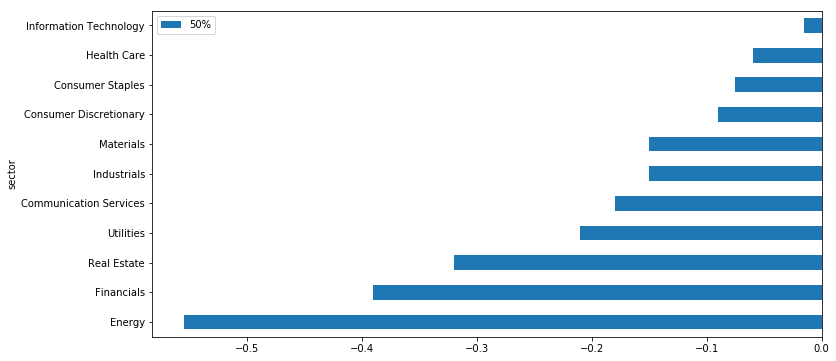

In [203]:
russell_3000.groupby('sector')['ytd_return'].describe()['50%'].sort_values().plot(kind='barh', figsize=[12,6], legend=True)

Interestingly enough, it appears that the rankings held up for the most part, but it did knock off healthcare from the leader to 2nd behind IT. It is somewhat troubling that the median for each sector has been negative across the board to varying degrees. As shown in all of the data above, the indexes (market-cap weighted) have been a horrible representation of the overall performance of the stock market year-to-date, as performance has been inflated upwards by a handful of outliers in each grouping we have examined. Referring back to the market cap decile example a few cells earlier, we can also see that the only decile with a positive median year-to-date performance has been the top decile by market cap. 

In [204]:
industry_stats = russell_3000.groupby('industry')['ytd_return'].describe()
industry_stats

,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
0,2.0,-0.075000,0.190919,-0.21,-0.1425,-0.075,-0.0075,0.06
Aerospace & Defense,29.0,-0.252414,0.265096,-0.76,-0.4400,-0.190,-0.0700,0.18
Automobiles & Auto Parts,31.0,0.135484,1.376108,-0.60,-0.3400,-0.210,-0.1100,6.48
Banking Services,317.0,-0.395710,0.173159,-0.74,-0.4800,-0.430,-0.3500,1.07
Beverages,13.0,0.316923,0.939365,-0.39,-0.1300,-0.020,0.2200,3.09
Biotechnology & Medical Research,230.0,0.339652,2.210579,-0.75,-0.2900,-0.045,0.3675,24.55
Chemicals,55.0,-0.102727,0.422525,-0.48,-0.3000,-0.150,-0.0350,2.68
Coal,4.0,-0.410000,0.434434,-0.67,-0.6250,-0.605,-0.3900,0.24
Communications & Networking,40.0,-0.097750,0.350827,-0.61,-0.3050,-0.175,0.0125,1.22


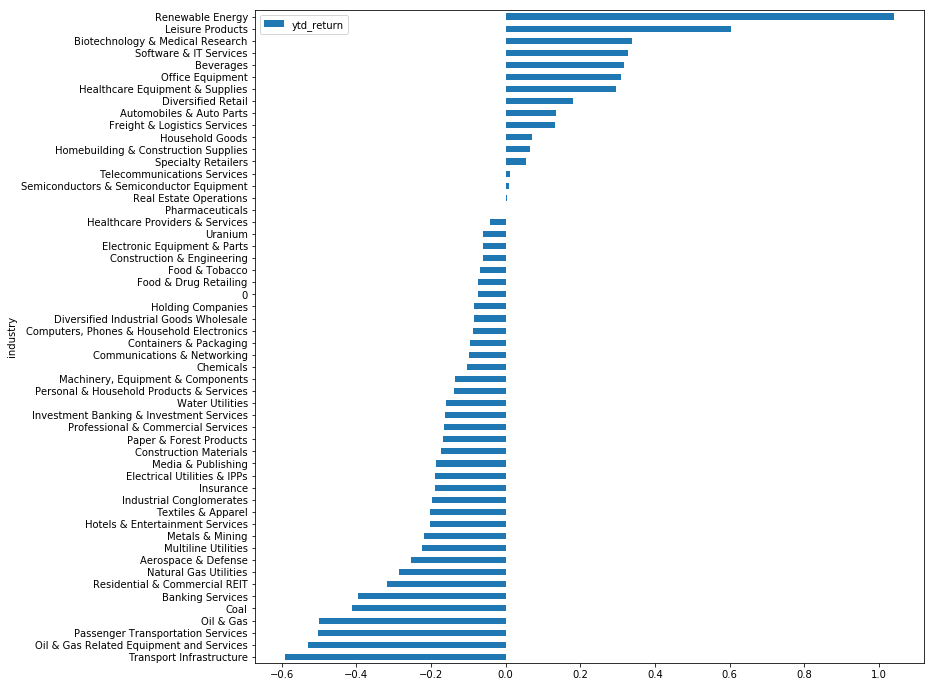

In [205]:
russell_3000.groupby('industry')['ytd_return'].mean().sort_values().plot(kind='barh', figsize=[12,12], legend=True)

Industries? I put this here for reference, but it is obviously too much data to be worth examining in this notebook. I will save this for a later date and look at industry performance leading up to the election and follow up with how performance changed after the election (or not).

Lets take one final look at another way to look at the market, but expand our analysis globally and include fixed income. For convenience, I created a CSV file that I use to break apart performance globally to see what has and has not worked with ETF's that represent a wide variety of styles, regions, and security types.

In [206]:
etfs_by_factor = pd.read_csv('etf_types.csv')

In [207]:
factor_tickers = etfs_by_factor['ticker'].to_list()

In [208]:
factor_adjusted_close = pd.DataFrame(columns=factor_tickers)
null_tickers = []

for ticker in factor_tickers:
  try:
    data_panel = web.DataReader([ticker], "tiingo").loc[ticker]['adjClose'].to_frame()
    data_panel.columns = [ticker]
    data_panel.index = pd.to_datetime(data_panel.index)
    if data_panel.index.max().tz_localize(None) < datetime.today() - relativedelta(days=5):
        print("{} most recent date is {}".format(ticker, str(data_panel.index.max())))
    else:
        factor_adjusted_close[ticker] = data_panel[ticker]
  except:
    null_tickers.append(ticker)
    print("{} not found".format(ticker))

In [209]:
filtered_factor_adjusted_close = factor_adjusted_close.loc['2019-12-31':]

In [210]:
etfs_by_factor.set_index('ticker', inplace=True)

In [211]:
for ticker in filtered_factor_adjusted_close.columns:
    etfs_by_factor.loc[ticker, 'ytd_return'] = (filtered_factor_adjusted_close[ticker].iloc[-1] - filtered_factor_adjusted_close[ticker].iloc[0])/filtered_factor_adjusted_close[ticker].iloc[0]
    etfs_by_factor.loc[ticker, 'peak_to_trough'] = (filtered_factor_adjusted_close[ticker].loc[trough] - filtered_factor_adjusted_close[ticker].loc[peak])/filtered_factor_adjusted_close[ticker].loc[peak]
    etfs_by_factor.loc[ticker, 'trough_to_date'] = (filtered_factor_adjusted_close[ticker].iloc[-1] - filtered_factor_adjusted_close[ticker].loc[trough])/filtered_factor_adjusted_close[ticker].loc[trough]
    etfs_by_factor.loc[ticker, 'start_to_peak'] = (filtered_factor_adjusted_close[ticker].loc[peak] - filtered_factor_adjusted_close[ticker].iloc[0])/filtered_factor_adjusted_close[ticker].iloc[0]

In [212]:
etfs_by_factor.sort_values(by='ytd_return', ascending=False).head(10)

,asset_class,type,factor,ytd_return,peak_to_trough,trough_to_date,start_to_peak
ticker,,,,,,,
IPO,equity,qualitative,ipo,0.631696,-0.332509,1.164173,0.129540
TLT,fixed_income,us_treasury_duration,20_plus_year_treasury,0.227017,0.142357,-0.001726,0.075967
CWB,fixed_income,us_corporate_credit,convertibles,0.216678,-0.320608,0.643655,0.089543
IWF,equity,style,growth,0.184621,-0.315461,0.583214,0.093054
TLH,fixed_income,us_treasury_duration,10_20_year_treasury,0.175230,0.112517,0.002433,0.053807
IVW,equity,size_vs_value,large_cap_growth,0.152948,-0.313515,0.544389,0.087482
PLW,fixed_income,us_treasury_duration,laddered_treasury,0.151535,0.095514,0.005569,0.045316
MTUM,equity,style,momentum,0.128250,-0.340823,0.567762,0.091749
IEF,fixed_income,us_treasury_duration,7_10_year_treasury,0.115282,0.063763,0.017122,0.030783


The top ten performers year-to-date across these asset classes we examined are shown above. Roughly half are fixed income and the other half are equity. IPOs (as represented by the ETF with ticker IPO) has been the clear winner so far. I will dive deeper into that in a seperate piece. The second best performance has been from long-duration treasuries, which shouldn't be that surprising given the zero interest rate policy that the Fed put back in place in March of this year.

In [213]:
etfs_by_factor.sort_values(by='ytd_return', ascending=False).tail(10)

,asset_class,type,factor,ytd_return,peak_to_trough,trough_to_date,start_to_peak
ticker,,,,,,,
VYM,equity,style,high_dividend_yield,-0.137354,-0.346374,0.316694,0.002348
PKW,equity,qualitative,buybacks,-0.140367,-0.396632,0.420605,0.002899
IVE,equity,size_vs_value,large_cap_value,-0.141397,-0.368233,0.346217,0.009532
IWD,equity,style,value,-0.141565,-0.383719,0.375592,0.012603
KNOW,equity,qualitative,insider_sentiment,-0.151528,-0.391635,0.394322,0.000254
CSD,equity,qualitative,spin_offs,-0.172612,-0.519009,0.742342,-0.012723
IJR,equity,style,small_cap,-0.184944,-0.412208,0.391620,-0.003578
EFV,equity,global_style,international_value,-0.191864,-0.363132,0.302040,-0.025436
IJJ,equity,size_vs_value,mid_cap_value,-0.224159,-0.452110,0.420628,-0.003221


The results here look fairly consistent with our previous analysis, where we found that the market has penalized Smaller Market Cap companies, and that it has also penalized low P/E (cheaper) companies. No surpise that if you were both a small company and had a cheap valuation, you were left in the dust performance wise. The worst performance year-to-date was in Small Cap Value, Mid Cap Value, and International Value which makes it look like the market penalized cheap companies more than small cap companies so far.

Now let's look at equity on it's own.

In [214]:
equity_factors = etfs_by_factor[etfs_by_factor['asset_class'] == 'equity']

In [215]:
equity_factors.set_index('factor', inplace=True)

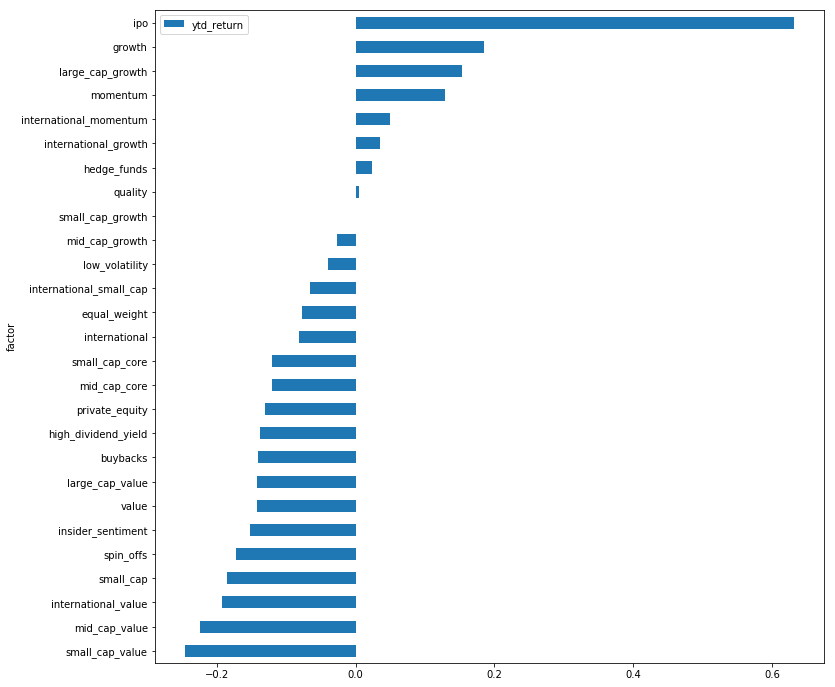

In [216]:
equity_factors['ytd_return'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

The same pattern emerges...the smaller and cheaper companies were dominated by speculative or large cap companies year to date. The top 5 are either momentum based, growth, or IPOs. It almost leads me to conclude that most of the smart money is still on the sidelines, and investors-to-date have been treating the market as a substitute for not being able to gamble on sports or go to the casino (just speculating here)..

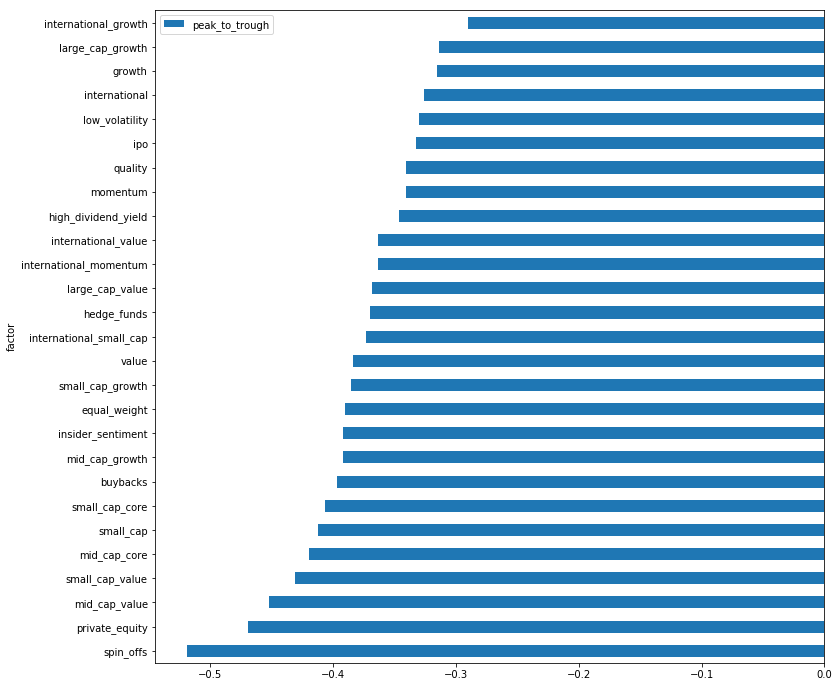

In [217]:
equity_factors['peak_to_trough'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

From the market's peak in February to the trough in March of this year, small cap and value both were hit the hardest and sold off the most during the rapid market decline, while the same companies that have outperformed year-to-date were also penalized far less in the drawdown.

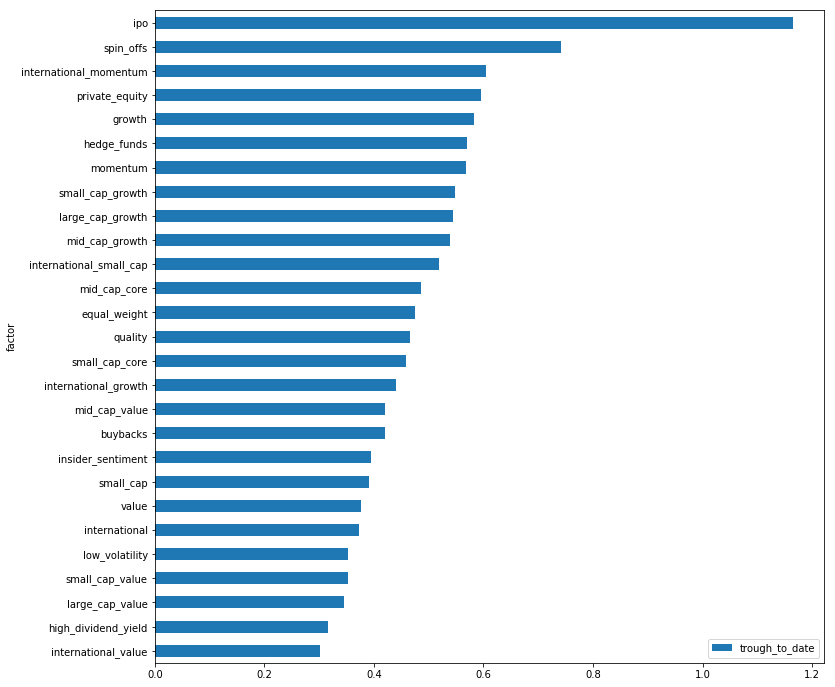

In [218]:
equity_factors['trough_to_date'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

From the market bottom in March to today, you see the same bunch that held up the best in the correction, have outperformed in the recovery (with the exception of the spin-offs, which were both hit the hardest and performed the best out of the trough of the market).

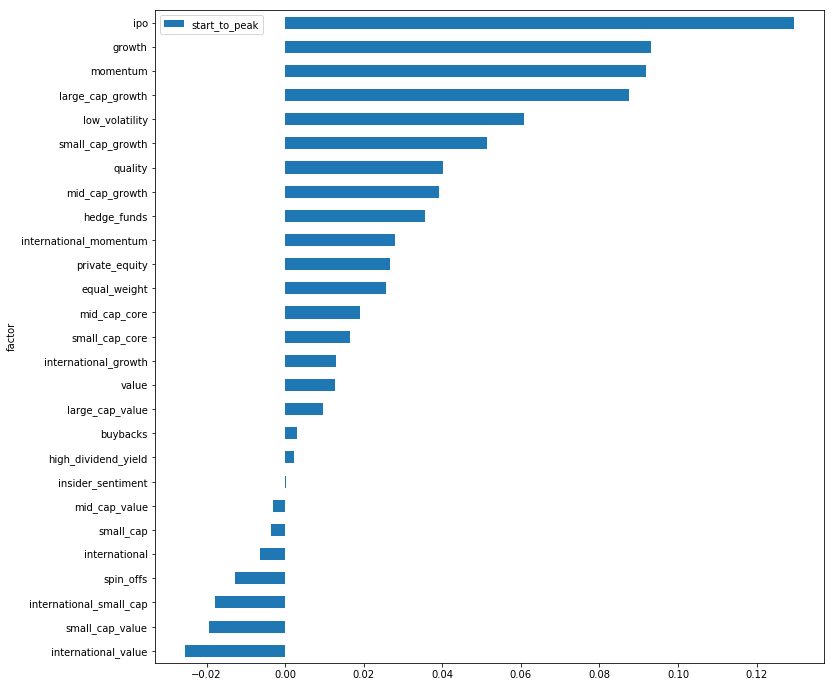

In [219]:
equity_factors['start_to_peak'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

The year started out very similarly, with the most expensive and largest companies as clear favorites leading up to the Februrary drawdown.

Finally, we take a look at fixed income by factors.

In [220]:
fixed_income_factors = etfs_by_factor[etfs_by_factor['asset_class'] == 'fixed_income']

In [221]:
fixed_income_factors.set_index('factor', inplace=True)

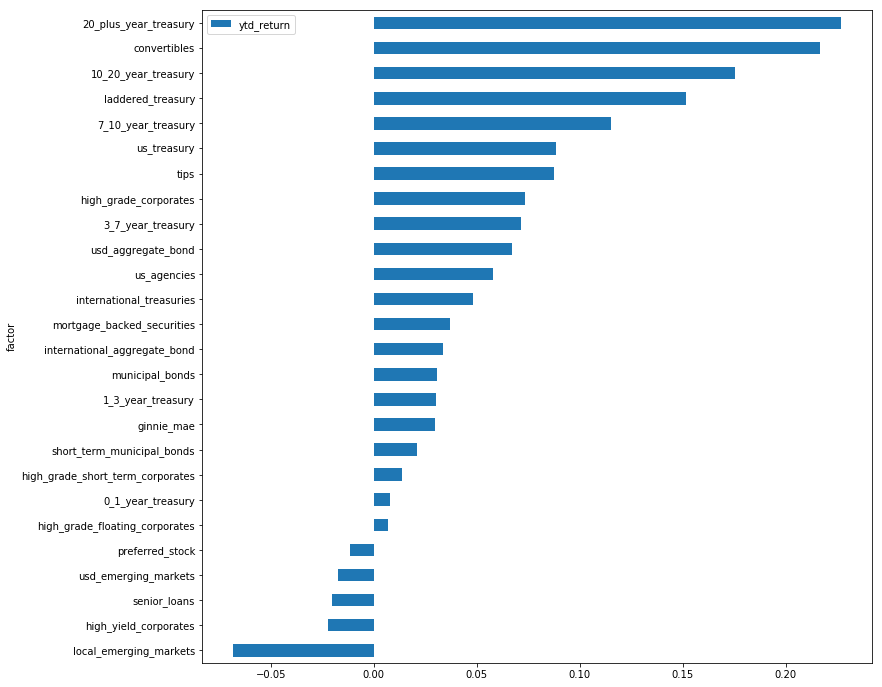

In [222]:
fixed_income_factors['ytd_return'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

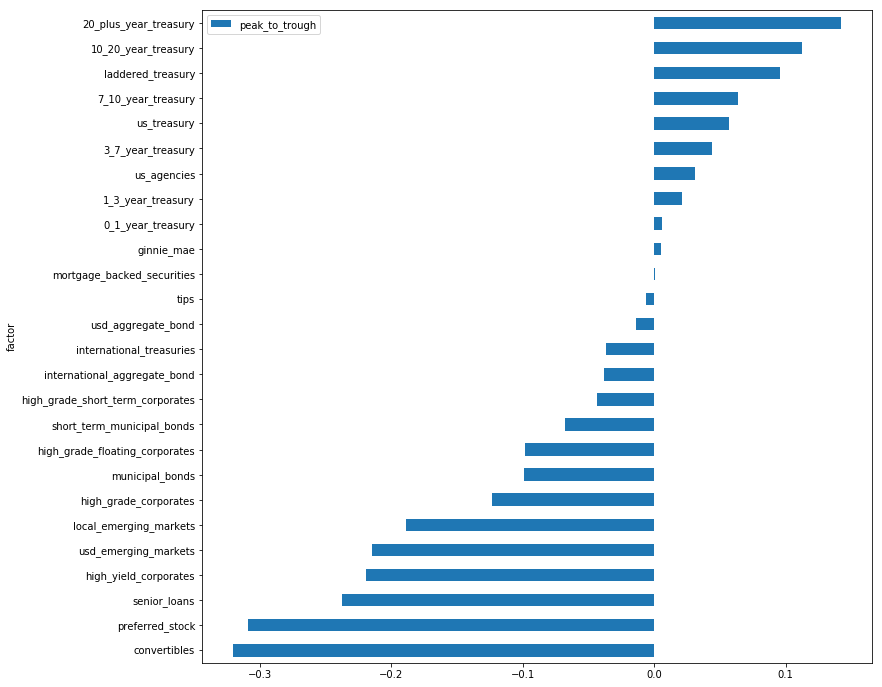

In [223]:
fixed_income_factors['peak_to_trough'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

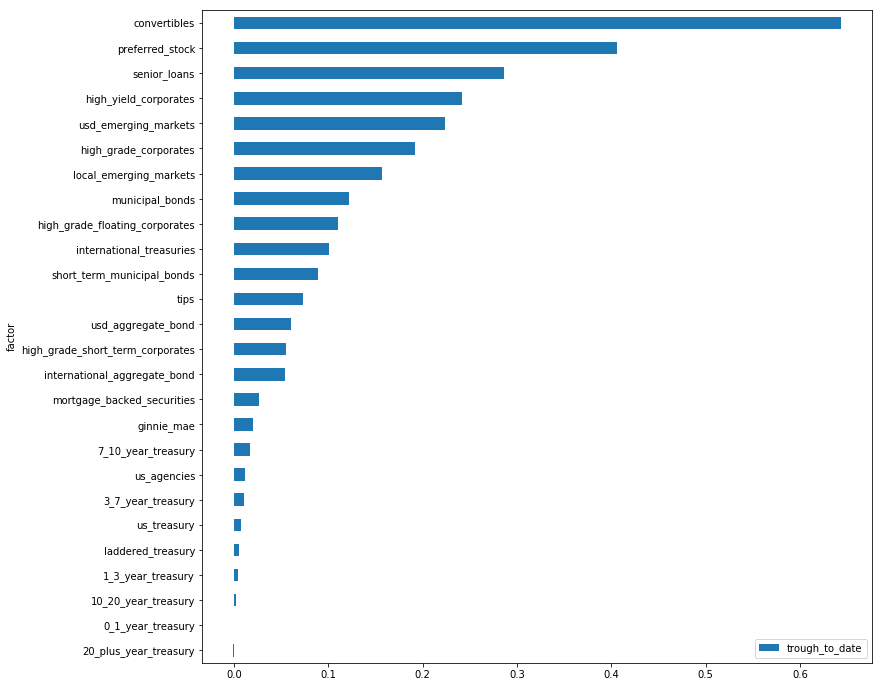

In [224]:
fixed_income_factors['trough_to_date'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

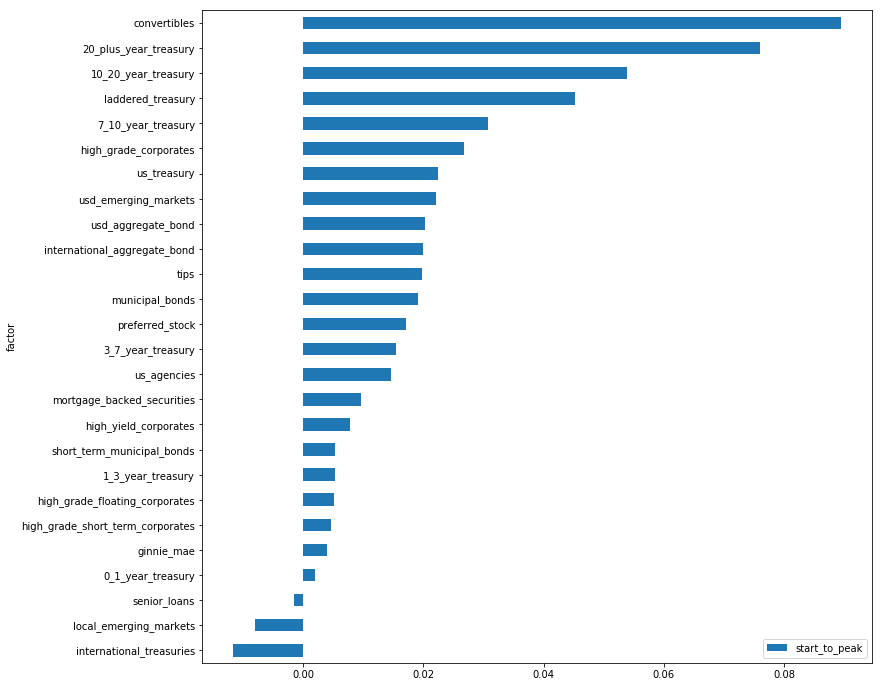

In [225]:
fixed_income_factors['start_to_peak'].sort_values().plot(kind='barh', figsize=[12,12], legend=True)

I am not going to say too much here, but the convertible bond performance has been interesting. YTD it was the second best performer behind long duration treasuries, the worst performer during the drawdown in February, and was the best performer coming out of the bottom in the market, and was the leader from the start of the year up until the peak of the market in February. That one is worth exploring down the road and digging in a bit further to see what may or may not be driving that one.

In conclusion, it is hard to look at the performance in the equity markets and think the market internals are healthy at this point. The positive performance shown in the market-cap weighted indices year-to-date has been extremely top-heavy, with mega cap companies getting even larger and small cap companies getting smaller on a relative basis, and expensive companies have been getting more expensive, while cheap companies have been getting cheaper.

I can't help but think that this may represent a once in a generation entry point for investors that need to deploy cash that is on the sidelines. The market is not trading based on fundamentals, which is nothing new, but at some point this will normalize. I am not sure what the catalyst will be, but I have to imagine the US will start to enforce Antitrust laws again at some point and force the top 10 companies by size to break up into smaller companies. Competition is one of the hallmarks of capitalism, and it appears to be on hiatus at the moment. Investors appear to have lost faith in the concept, and are shoveling money into expensive companies just because they are large and dominate their sectors or industries.

The bright side is that for patient investors, their are a lot of bargains present in the market today, and even within the S&P 500 you can find relative value by avoiding the top 100 by market cap. There is a record amount of cash sitting on the sidelines and at some point, investors will be dissatisfied with earning close to 0% on their cash holdings, and I want to be on the right side of that trade.

Data sources used in this notebook: Finnhub (finnhub.io) and Tiingo (tiingo.com) APIs